In [ ]:
!mkdir sparse_vector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils import data
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm import tqdm
from datetime import datetime
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
# from sparse_vector.sparse_vector import SparseVector
from scipy.signal import convolve2d, convolve
import time
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
ASSEMBLY_d = {}
chroms_d = {}
G4DNA_d = {}
DNA_d = {}

# G4

In [ ]:
ASSEMBLY = "G4_cut_small"
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X']]
G4DNA = load(f'{ASSEMBLY}.pkl')



In [ ]:
%%capture
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'/content/drive/My Drive/DeepZ_data_creation/data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"/content/drive/My Drive/DeepZ_data_creation/data/hg19_dna/{file}") for file in files])


DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}

In [ ]:
mode = 'hg19'
ASSEMBLY_d[mode] = ASSEMBLY
chroms_d[mode] = chroms
G4DNA_d[mode] = G4DNA
DNA_d[mode] = DNA

# Data part

In [ ]:
mode = 'hg19'
ASSEMBLY = ASSEMBLY_d[mode]
chroms = chroms_d[mode]
G4DNA = G4DNA_d[mode]
DNA = DNA_d[mode]

In [ ]:
%%capture
width = 512

np.random.seed(10)

ints_in = []
ints_out = []


for chrm in chroms:
    for st in trange(0, G4DNA[chrm].shape - width, width):
        interval = [st, min(st + width, G4DNA[chrm].shape)]
        N_count = sum([bp == "N" for bp in DNA[chrm][interval[0]:interval[1]]])
        if N_count > width / 2:
            continue
        else:
            if G4DNA[chrm][interval[0]: interval[1]].any():
                ints_in.append([chrm, int(interval[0]), int(interval[1]), 1])
            else:
                ints_out.append([chrm, int(interval[0]), int(interval[1]), 0])




print(len(ints_in))
print(len(ints_out))

ints_in_full = ints_in
ints_out_full = ints_out


In [ ]:
ints_in = ints_in_full
ints_out = [ints_out_full[i] for i in np.random.choice(range(len(ints_out_full)),
                                                    size=len(ints_in) * 20, replace=False)]
# ints_out = ints_out_full

print(len(ints_in))
print(len(ints_out))
#484 for len 1000
#9680 for len 1000

#629 for len 512
#12580 for len 5121

1413
28260


In [ ]:
equalized = ints_in + ints_out

In [ ]:
divisions = list(StratifiedKFold(5, shuffle=True,
                                 random_state=42).split(equalized, [f"{elem[3]}_{elem[0]}"
                                         for i, elem
                                         in enumerate(equalized)]))

In [ ]:
dump([equalized, divisions], 'zdna_divisions.pkl', 3)

['zdna_divisions.pkl']

In [ ]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers

    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.

    Returns:
    kmers -- str, kmers separated by space
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, chroms,
                 dna_source,
                 labels_source, intervals, tokenizer):

        self.chroms = chroms
        self.dna_source = dna_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.configs = {
                        'ZHUNT_AS': {
                                'CG': 0, 'GC': 1, 'CA': 0, 'AC': 1,
                                'TG': 0, 'GT': 1, 'TA': 1, 'AT': 1,
                                'CC': 0, 'GG': 0, 'CT': 1, 'TC': 1,
                                'GA': 1, 'AG': 1, 'AA': 1, 'TT': 1},
                       }
        seqs = (["A", "C", "T", "G"] +
                ['AC', 'AT', 'AG', 'CT', 'CG', 'GT'] +
                ['AAC', 'ACC', 'AAT', 'ATT', 'AAG', 'AGG',
                 'CCA', 'CAA', 'CCT', 'CTT', 'CCG', 'CGG',
                 'TTA', 'TAA', 'TTC', 'TCC', 'TTG', 'TGG',
                 'GGA', 'GAA', 'GGC', 'GCC', 'GGT', 'GTT'] +
                ['AAAC', 'AAAT', 'AAAG', 'CCCA', 'CCCT', 'CCCG',
                 'TTTA', 'TTTC', 'TTTG', 'GGGA', 'GGGC', 'GGGT'])
        self.tars = np.array([self.le.transform(list(i * 11)[:11]) for i in seqs])[:, ::-1, ::-1]
        # purine-pyrimidine
        self.tars = np.concatenate((self.tars, np.array([self.tars[4] + self.tars[9]])))
        self.tokenizer = tokenizer


    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        ll = list(self.dna_source[chrom][begin:end].upper())
        y = self.labels_source[interval[0]][interval[1]: interval[2]]


#         DNA PART

        dna_OHE = self.le.transform(ll)[None]

        res = pd.DataFrame(convolve(dna_OHE, self.tars)[:, 5:-5, 3].T / 11)
        res = (res.rolling(5, min_periods=1).max().values == 1).astype(int)


        X = dna_OHE.astype(np.float32)

        #K-mer part

        k_mers = seq2kmer(self.dna_source[chrom][begin:end+5].upper(), 6)
        encoded_k_mers = self.tokenizer.encode_plus(k_mers, add_special_tokens=False, max_length=512)["input_ids"]

        return torch.Tensor(X), torch.Tensor(y).long(), ll, torch.LongTensor(encoded_k_mers), (chrom, begin, end)


In [ ]:
import torch
from transformers import BertModel, BertConfig, PreTrainedTokenizer, BasicTokenizer, BertForTokenClassification
import collections
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoConfig, AutoModelForSequenceClassification

In [ ]:
%%capture
!pip install einops
import einops

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t')
model = AutoModel.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', trust_remote_code=True)
# gena_module_name = model.__class__.__module__
# cls = getattr(importlib.import_module(gena_module_name), 'BertForSequenceClassification')
# model = cls.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', num_labels=2, output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

modeling_bert.py:   0%|          | 0.00/97.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/AIRI-Institute/gena-lm-bert-base-t2t:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/541M [00:00<?, ?B/s]

In [ ]:
%%capture
!FLASH_ATTENTION_SKIP_CUDA_BUILD=TRUE pip install flash-attn --no-build-isolation

In [ ]:
# model_name = "/content/drive/My Drive/DNABERT-2-117M"
# model_name = "/content/drive/My Drive/dna_bert"
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", config=config, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df = pd.read_csv('/content/endo_fasta.csv')

In [ ]:
chunk_size = 10000
num_chunks = len(df) // chunk_size + int(len(df) % chunk_size != 0)

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))
    chunk = df['raw_sequence'][start_idx:end_idx]

    embeddings = []

    for seq in chunk:
        inputs = tokenizer(seq, return_tensors='pt')["input_ids"]
        hidden_states = model(inputs)[0]
        embedding_mean = torch.mean(hidden_states[0], dim=0)
        embeddings.append(embedding_mean.detach().numpy())

    np.save(f'embeddings_chunk_{i}.npy', np.array(embeddings))
    print(f"Processed and saved chunk {i + 1}/{num_chunks}")

In [ ]:
chunk_embeddings = np.load(f'/content/embeddings_chunk_1.npy')

In [ ]:
all_embeddings = []

for i in range(40):
    chunk_embeddings = np.load(f'embeddings_chunk_{i}.npy')
    all_embeddings.append(chunk_embeddings)

all_embeddings = np.concatenate(all_embeddings, axis=0)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/g4seq_dataset.csv")

In [ ]:
df

,sequence,label,split
0,GTCTGGGATGCATTTGGTATTACACTGTAGGCAGGACCCGCTTGT,0,train
1,GCTACTCACACGTATAAAGGTCTGAAGACACACAATTTGGATGCGA...,0,test
2,cctgcagccacccatgcctgcgcctcccccc,1,test
3,CCCCTCCCCCACGGCCGGCAGCGACGCCCGGACTCC,1,train
4,ccgccctcgccccgccccggctcctcccccc,1,train
...,...,...,...
782945,GGTTATAATGTATGGATACTTACCGATCAGGGCTTCCGC,0,train
782946,CTCCCCGCCCCCCCCAACCCCGTCCCCCC,1,test
782947,CGCTTGCAAATAGAAAAATTTGATGATGCGATAG,0,train
782948,AGGAATAATATCGACGGCACACGC,0,train


In [ ]:
%%capture
!pip install umap
!pip install hdbscan

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
all_embeddings.shape

(391475, 768)

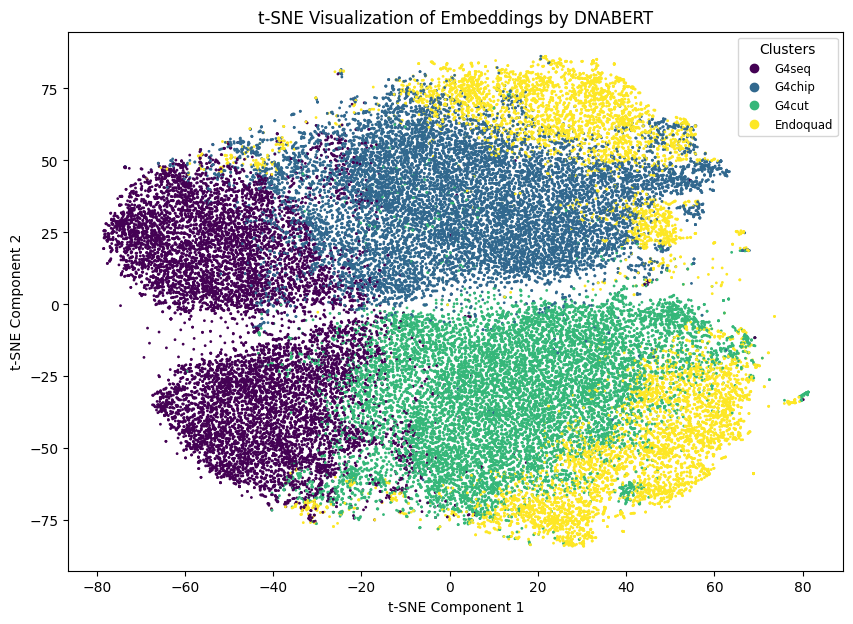

In [ ]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 7))
# # cluster_colors = ['purple', 'blue', 'green', 'yellow']
# color_map = mcolors.ListedColormap(cluster_colors)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=1, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings by DNABERT')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

handles, _ = scatter.legend_elements()
# cluster_names = [f'Cluster {i}' for i in range(num_clusters)]
cluster_names = ['G4seq', 'G4chip', 'G4cut', 'Endoquad']
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')

plt.show()


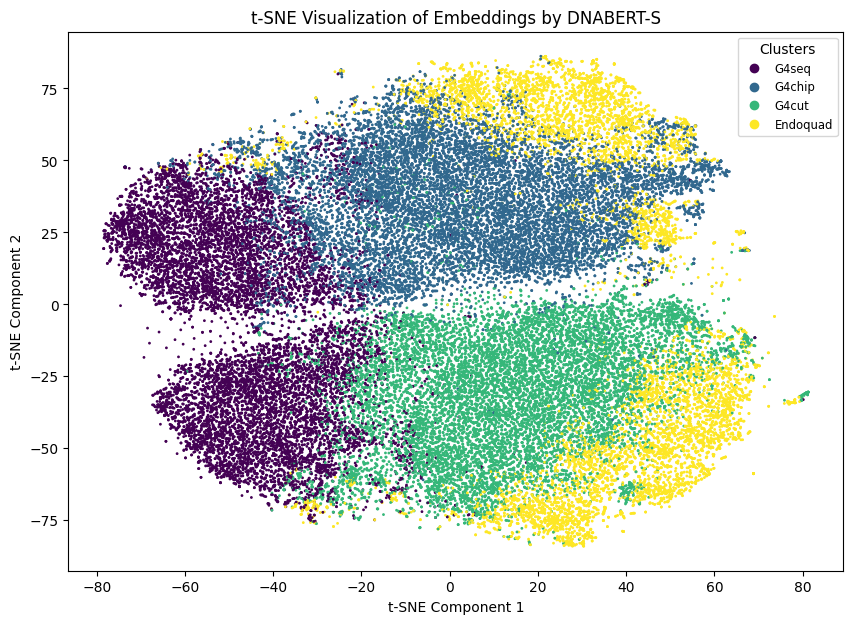

In [ ]:
plt.figure(figsize=(10, 7))
# # cluster_colors = ['purple', 'blue', 'green', 'yellow']
# color_map = mcolors.ListedColormap(cluster_colors)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=1, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings by DNABERT-S')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

handles, _ = scatter.legend_elements()
# cluster_names = [f'Cluster {i}' for i in range(num_clusters)]
cluster_names = ['G4seq', 'G4chip', 'G4cut', 'Endoquad']
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')

plt.show()

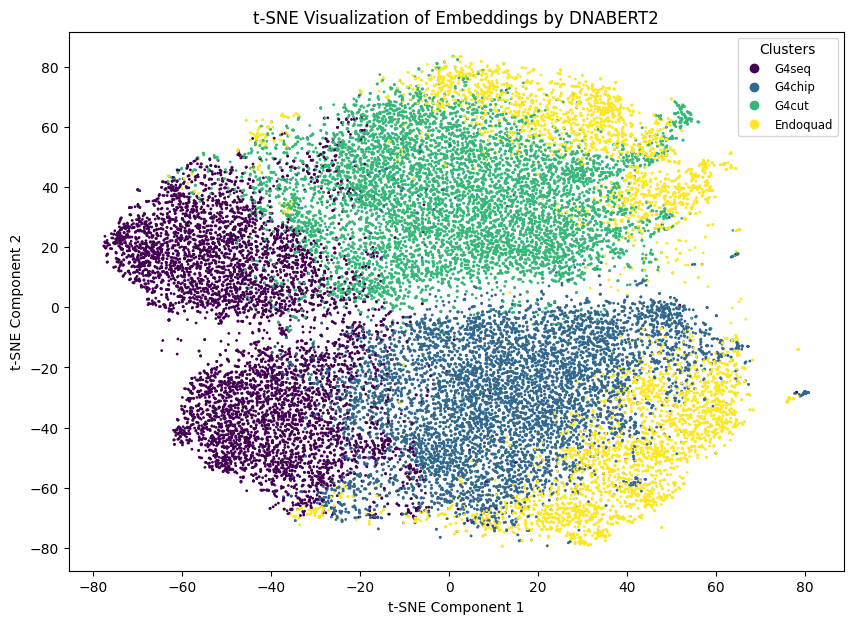

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=1, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings by DNABERT2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

handles, _ = scatter.legend_elements()
# cluster_names = [f'Cluster {i}' for i in range(num_clusters)]
cluster_names = ['G4seq', 'G4chip', 'G4cut', 'Endoquad']
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')

plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
for MODEL_NUMBER in range(5):

    train_inds, test_inds = divisions[MODEL_NUMBER]
    train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

    random.shuffle(train_intervals)
    random.shuffle(test_intervals)

    train_dataset = Dataset(chroms,
                       DNA, G4DNA, train_intervals,
                        AutoTokenizer.from_pretrained(model_name, trust_remote_code=True))

    test_dataset = Dataset(chroms,
                       DNA,  G4DNA, test_intervals,
                          AutoTokenizer.from_pretrained(model_name, trust_remote_code=True))

    dump((train_dataset, test_dataset), f'zdna_seq_hg_fold{MODEL_NUMBER}.pkl')

In [ ]:
config = BertConfig.from_pretrained(model_name)
model = BertForTokenClassification.from_pretrained(model_name, config=config)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/My Drive/dna_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = 'cuda'

In [ ]:
attentions, preds, targets, seqs, bps, hidden_states = [], [], [], [], [], []

for FOLD in range(5):
    train_dataset, test_dataset = load(f'zdna_seq_hg_fold{FOLD}.pkl')
    model.to(device)

    for example in tqdm(test_dataset):
        features, target, seq, input_ids, interval = example
        if target.numpy().sum()>0:
            with torch.no_grad():
                outputs = model(input_ids.unsqueeze(0).to(device))

                pred = torch.softmax(outputs[0], axis = -1)[0,:,1]
                attention = outputs[-1]


            attentions.append(attention)
            preds.append(pred)
            targets.append(target)
            seqs.append(seq)

 74%|███████▍  | 4403/5935 [00:58<00:19, 78.99it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.
100%|██████████| 5934/5934 [01:17<00:00, 76.72it/s]


In [ ]:
attentions, preds, targets, seqs, bps = [], [], [], [], []
for FOLD in range(5):
    train_dataset, test_dataset = load(f'zdna_seq_hg_fold{FOLD}.pkl')
    model.to(device)

    for example in tqdm(test_dataset):
        features, target, seq, input_ids, interval = example
        if target.numpy().sum()>0:
            with torch.no_grad():
                outputs = model(input_ids.unsqueeze(0).to(device))

                pred = torch.softmax(outputs[0], axis = -1)[0,:,1]
                attention = outputs[-1]


            attentions.append(attention)
            preds.append(pred)
            targets.append(target)
            seqs.append(seq)

100%|██████████| 5934/5934 [01:26<00:00, 68.74it/s]


In [ ]:
seqs

In [ ]:
attentions[-1][0,:,:]

tensor([[ 0.0987, -0.9657],
        [-0.2977, -1.3823],
        [-0.4168, -0.6559],
        ...,
        [-0.0033, -0.4786],
        [-0.0404, -0.8978],
        [ 0.2776, -0.8944]], device='cuda:0')

In [ ]:
attention

tensor([[[ 0.2046,  0.3417],
         [ 0.2340,  0.1748],
         [ 0.2459,  0.2654],
         ...,
         [ 0.0461,  0.4532],
         [ 0.2387,  0.2145],
         [-0.3500,  0.5440]]], device='cuda:0')

In [ ]:
from collections import defaultdict
kmer2pred = defaultdict(int)
kmer2att = defaultdict(float)


for attention, pred, target, seq in tqdm(zip(attentions, preds, targets, seqs)):
    kmer = seq2kmer(''.join(seq), 3).split(' ')
    # print(kmer)
    # print(len(kmer))
    att = attention[-1]
    # print(att.shape)

    for idx in range(512-5):
        if target[idx]>0:
            kmer2pred[kmer[idx]]+=1
            #print(kmer2pred)
            for head in range(12):
                # print(att[head])
                c_att = att[head].cpu().numpy()
                for att_idx in range(512-5):
                    kmer2att[kmer[att_idx]]+=c_att

1413it [37:08,  1.58s/it]


In [ ]:
sorted_pred = [t[0] for t in sorted(kmer2pred.items(), key=lambda item: -item[1])]
kmer2att2 = {k:int(kmer2att[k][0] + kmer2att[k][1]) for k in kmer2att}
sorted_att = [t[0] for t in sorted(kmer2att2.items(), key=lambda item: -item[1])]

In [ ]:
len(sorted_pred)

64

In [ ]:
import pickle

In [ ]:
with open('bert2_k=3.pickle', 'wb') as handle:
    pickle.dump(sorted_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

# k =6

In [ ]:
for idx, kmer in enumerate(sorted_att):
    print(idx+1, kmer, sorted_pred.index(kmer)+1)
    if idx>100:
        break

1 GCCCTG 14
2 CCTCCC 5
3 GGGAGG 7
4 CCCGCC 2
5 CCTGCC 18
6 CCGCCC 1
7 GGCGGG 3
8 CCTGGC 28
9 GGGCGG 4
10 CCCAGC 12
11 CCCTGG 32
12 CCCCGC 6
13 CCCAGG 10
14 CTGCCC 26
15 CCCTGC 29
16 CTGGCC 46
17 GCCCCG 9
18 GCGGGG 8
19 CCCTCC 16
20 GCTGGG 19
21 TTTTTT 41
22 GGCCCC 13
23 CCCCAG 24
24 CCTGGG 22
25 GGCCCT 66
26 CGCCCC 11
27 CCAGGC 27
28 CAGCCC 38
29 CCAGCC 31
30 GGGGCG 15
31 TGGCCC 87
32 CTGGGC 35
33 GGAGGG 34
34 CTCCCC 42
35 GGAGGC 36
36 GCCGCC 17
37 GCCTGG 43
38 GGGGCC 25
39 GGGCTG 49
40 CCCGGG 21
41 GCCTCC 33
42 GCCCAG 37
43 GCCCCC 39
44 CGGGGC 20
45 CTGGGG 44
46 CCCGGC 23
47 GGGGGC 48
48 AAAAAA 92
49 GGCAGG 56
50 GGCGGC 30
51 GGGGAG 54
52 GGCTGG 52
53 CCCCTC 50
54 GGGCCC 55
55 GCCAGG 65
56 GGCCTG 63
57 GCAGGG 59
58 CCAGGG 61
59 CCCCGG 47
60 CCGGCC 51
61 GTGGGG 77
62 GGGCAG 68
63 CAGGCC 72
64 CAGGGC 67
65 CGCCGC 40
66 GGTGGG 74
67 CCGGGC 53
68 CCCCCA 99
69 AGCCCC 82
70 GCCCGG 45
71 GGCTGC 94
72 CCCACC 79
73 CCCCAC 85
74 CCTCCT 89
75 GAGGAG 98
76 GAGGGG 90
77 GGCCGC 58
78 GAGGCC 96
79 C

#k=5

In [ ]:
for idx, kmer in enumerate(sorted_att[:len(sorted_pred)]):
    print(idx+1, kmer, sorted_pred.index(kmer)+1)
    if idx>100:
        break

1 CCGCC 3
2 CCCCG 14
3 GCGGG 15
4 CCCGG 19
5 GGGCG 18
6 GGCGG 7
7 CCCGC 13
8 GCCCC 1
9 GGGGC 2
10 GCCGC 26
11 CGCCC 16
12 CGGGG 21
13 CCGGG 25
14 CCTCC 6
15 GCGGC 39
16 GGCGC 51
17 CGGCC 44
18 GCGCC 47
19 CGCGG 68
20 CGCGC 67
21 GGCCG 43
22 CCGCG 69
23 CCGGC 52
24 GCGCG 78
25 CGGGC 48
26 GCCCG 49
27 GGCCC 4
28 GGGCC 12
29 GGAGG 9
30 CGCCG 84
31 CTCCC 20
32 CCCCC 29
33 CGGCG 88
34 GGGGG 35
35 TCCCC 53
36 GCCGG 73
37 CTGGG 10
38 GGGAG 24
39 CCCTC 37
40 GCCTC 42
41 GGAGC 66
42 CCCCT 57
43 GCAGG 33
44 GCTGG 34
45 CCCAG 5
46 GAGGC 45
47 GAGGG 54
48 GGCTG 32
49 CCTGG 8
50 GCTCC 65
51 GGGGA 59
52 CGGAG 137
53 CGCCT 139
54 CTCCG 138
55 CCTGC 22
56 CCAGC 30
57 CTGCG 145
58 GGGCT 62
59 CAGCC 27
60 GTCCC 103
61 GGCAG 46
62 TCCCG 140
63 CAGGG 23
64 CCCTG 17
65 TGGGG 36
66 GCCTG 40
67 CCAGG 11
68 GGCCT 50
69 GCAGC 55
70 CGGGA 144
71 TGGGC 82
72 GCTGC 61
73 CAGGC 38
74 TTCCC 147
75 GGGAC 99
76 GAGCC 90
77 AGGGC 80
78 TCCTC 106
79 AGGCG 141
80 AGCCC 60
81 CCCCA 31
82 AGGGG 64
83 GGCTC 70
84 CTCGG 166

# k=4

In [ ]:
for idx, kmer in enumerate(sorted_att):
    print(idx+1, kmer, sorted_pred.index(kmer)+1)
    if idx>100:
        break

1 CCCC 2
2 GGGC 4
3 CCGC 13
4 CCCG 12
5 GCGG 16
6 GGGG 3
7 CGCC 15
8 GGCG 20
9 CGGG 17
10 GCCC 1
11 GCGC 31
12 CCGG 29
13 GGCC 5
14 GCCG 35
15 CGGC 34
16 CGCG 40
17 GGAG 11
18 CTCC 9
19 CCTC 14
20 TCCC 27
21 GAGG 22
22 GGGA 30
23 CTGG 8
24 TGGG 26
25 CCCT 19
26 GCAG 24
27 CAGG 7
28 CCTG 6
29 GCTG 25
30 GCCT 32
31 AGGG 28
32 CTGC 18
33 GAGC 44
34 CAGC 23
35 GGCT 36
36 CCAG 10
37 AGGC 33
38 AGCC 37
39 GCTC 38
40 CCCA 21
41 GTGG 43
42 GGAC 55
43 GTCC 59
44 TCCT 49
45 CGAG 104
46 TTCC 66
47 AGCG 89
48 CGCT 95
49 CTTC 72
50 CGGA 96
51 TCCG 98
52 AGGA 50
53 TGCG 110
54 GGGT 54
55 CTCG 100
56 GGTG 41
57 TGGC 45
58 TCTC 61
59 GGCA 51
60 GCGA 146
61 GGAA 78
62 TTTT 69
63 ACCC 46
64 GACC 63
65 GGTC 75
66 TCGG 131
67 CCTT 77
68 CACC 39
69 CCGA 127
70 GCCA 48
71 CCAC 42
72 TGCC 47
73 CTCT 52
74 CGCA 99
75 TTTC 101
76 GTGC 74
77 GAAG 82
78 CGTC 145
79 TCTG 53
80 TCGC 154
81 GCGT 143
82 CGTG 124
83 GACG 140
84 TTCT 94
85 TGGA 81
86 GCTT 117
87 AAGG 86
88 GAGA 73
89 CGGT 163
90 AGCT 76
91 CTGT 67
92 

# k=3

In [ ]:
for idx, kmer in enumerate(sorted_att):
    print(idx+1, kmer, sorted_pred.index(kmer)+1)
    if idx>100:
        break

1 CCC 1
2 GGG 2
3 GGC 4
4 GCC 3
5 GCG 14
6 CGC 11
7 CCG 10
8 CGG 12
9 TCC 17
10 CCT 7
11 GGA 18
12 CTC 9
13 GAG 13
14 AGG 8
15 CTG 5
16 GCT 20
17 TGG 15
18 AGC 19
19 CAG 6
20 TGC 23
21 CCA 16
22 GCA 24
23 GGT 27
24 GTC 30
25 GTG 22
26 TTC 35
27 TTT 31
28 ACC 25
29 CTT 32
30 TCT 26
31 CGA 51
32 GAC 29
33 TCG 52
34 GAA 40
35 AAG 33
36 CGT 50
37 AGA 28
38 ACG 49
39 AAA 37
40 GTT 48
41 CAC 21
42 TTG 43
43 TCA 34
44 AGT 44
45 TGT 38
46 CAA 42
47 AAC 47
48 TGA 39
49 GAT 53
50 ATC 54
51 ACT 41
52 AAT 55
53 ATG 46
54 CAT 45
55 TAG 58
56 ATT 57
57 CTA 56
58 TAA 59
59 GTA 62
60 TTA 60
61 TAC 61
62 ATA 63
63 ACA 36
64 TAT 64


ValueError: 'NNT' is not in list

#K

In [ ]:
len(''.join(map(str, sorted_pred))[:512])

512